In [1]:
import os

import pandas as pd

from src.dataPipeline import DataPipeline

os.chdir('..')

# New Model with different data

In [29]:
from sklearn.impute import SimpleImputer, KNNImputer
import numpy as np

#imputer = KNNImputer(n_neighbors=5)
imputer = SimpleImputer(strategy='constant', fill_value=None)

dp = DataPipeline()
df = dp.runPipeline(normalizeAndStandardize=True, imputer=imputer)
df_kaggle = dp.prepare_kaggle_dataset(filePath='./data/test_data-Kaggle-v0.11.csv', normalizeAndStandardize=True, imputer=imputer)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:46: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:73: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

In [3]:
 from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

pickle_dataframe(df, 'df_with_type.pkl')
pickle_dataframe(df_kaggle, 'df_kaggle_with_type.pkl')


DataFrame saved to df_with_type.pkl.
DataFrame saved to df_kaggle_with_type.pkl.


In [2]:
from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

df = unpickle_dataframe('df_with_bert_feature.pkl')
df_kaggle = unpickle_dataframe('df_with_bert_feature.pkl')

DataFrame loaded from df_with_bert_feature.pkl.
DataFrame loaded from df_with_bert_feature.pkl.


In [27]:
df = pd.read_csv('./data/immo_data_202208_v2.csv')
df_kaggle = pd.read_csv('./data/test_data-Kaggle-v0.11.csv')

# drop na values in column 'price_cleaned'
df = df.dropna(subset=['price_cleaned'])

df = df.drop(columns=['price'])

C:\Users\denis\AppData\Local\Temp\ipykernel_14188\3948826550.py:1: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/immo_data_202208_v2.csv')
C:\Users\denis\AppData\Local\Temp\ipykernel_14188\3948826550.py:2: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kaggle = pd.read_csv('./data/test_data-Kaggle-v0.11.csv')


In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split



y = df['price_cleaned']
y_log = np.log(y)

X = df.drop(columns=['price_cleaned'])


train_test_split_ratio = 0.01
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

model = XGBRegressor(objective='reg:squarederror', n_estimators=50, learning_rate=0.05, max_depth=9, max_leaves=0, reg_lambda=0, reg_alpha=1, grow_policy='depthwise')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = model.score(X_test, y_test)

print(f'Test MAPE: {mape:.3f}%, R2: {r2:.3f}')

# Train Mape
y_pred = model.predict(X_train)
y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_train, y_pred) * 100

print(f'Train MAPE: {mape:.3f}%')

Test MAPE: 20.232%, R2: -0.701
Train MAPE: 23.410%


In [17]:
from src.utils.helperFunctions import create_kaggle_results

results = model.predict(df_kaggle)
results = np.exp(results)
create_kaggle_results(results, csv_name='xgBoost_without_imputer_kaggle_results')

File xgBoost_without_imputer_kaggle_results_2024-12-26_13-56-31.csv created successfully.


C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


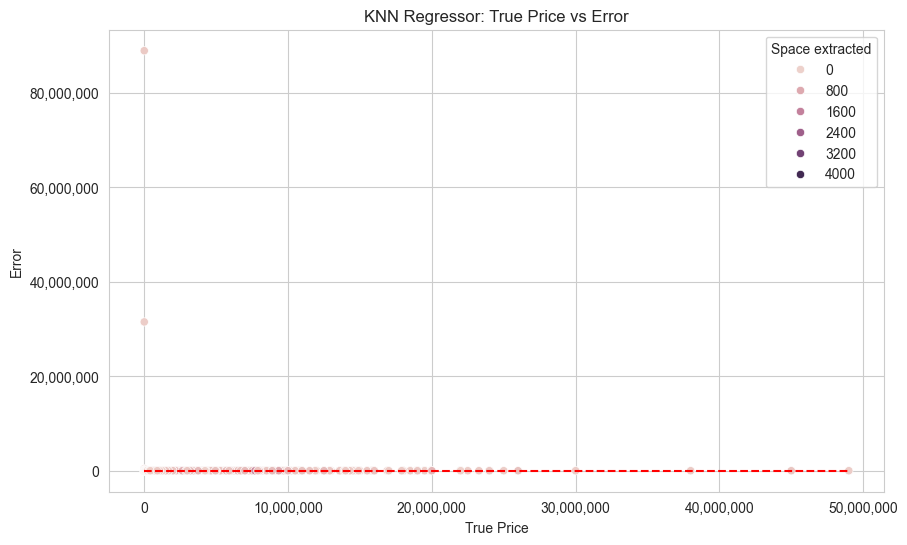

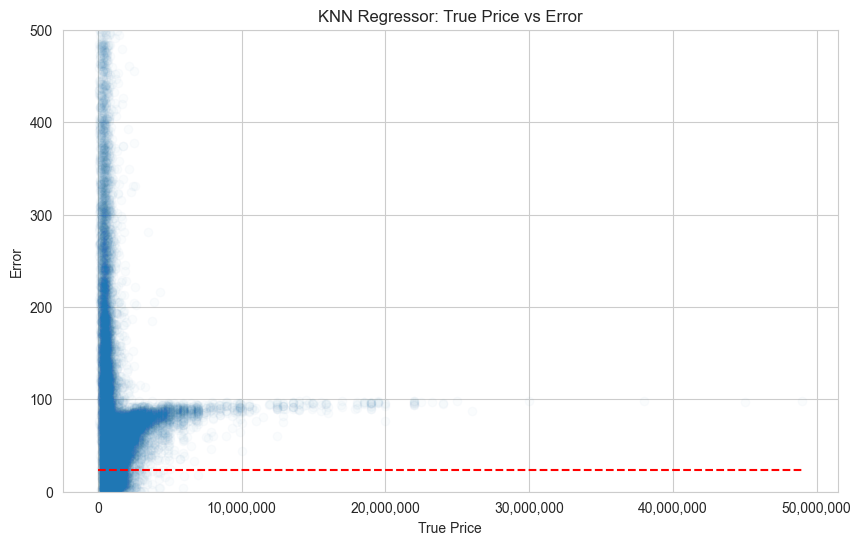

In [31]:
from src.utils.helperFunctions import analyse_highest_errors
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = np.exp(model.predict(X_train))
mape = mean_absolute_percentage_error(y_train, y_pred) * 100
error_analysis = analyse_highest_errors(y_train, y_pred, X_train, dp)
error_analysis
# Plot price vs error
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['mape'], hue=error_analysis['Space extracted'])
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title('KNN Regressor: True Price vs Error')
plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(x=error_analysis['true_price'], y=error_analysis['mape'], alpha=0.02)
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.ylim(0, 500)
plt.title('KNN Regressor: True Price vs Error')

plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()

In [32]:
error_analysis

,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,...,type_unified_stepped-apartment,type_unified_stepped-house,type_unified_studio,type_unified_terrace-house,type_unified_villa,provider_homegate.ch,true_price,predicted_price,error,mape
10690,0.00,0.00,0.00,0.44,0.43,0.50,0.01,0.02,0.04,0.14,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,889558.50,889557.50,88955750.00
3906,2.00,0.00,0.00,0.09,0.01,0.00,0.00,0.00,0.00,0.14,...,0.00,0.00,0.00,0.00,0.00,1.00,2.00,630333.25,630331.25,31516562.50
17882,2.00,0.00,0.00,0.73,0.64,0.56,0.00,0.00,0.00,0.05,...,0.00,0.00,0.00,0.00,0.00,1.00,550.00,2131875.25,2131325.25,387513.68
20194,0.00,0.00,0.00,0.06,0.00,0.00,0.03,0.00,0.00,0.47,...,0.00,0.00,0.00,0.00,0.00,0.00,745.00,1128832.12,1128087.12,151421.09
3614,0.00,0.00,0.00,0.21,0.09,0.03,0.00,0.00,0.00,0.26,...,0.00,0.00,0.00,0.00,0.00,0.00,1600.00,2206185.00,2204585.00,137786.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20484,0.00,0.00,110.00,0.01,0.00,0.00,0.00,0.00,0.00,0.25,...,0.00,0.00,0.00,1.00,0.00,0.00,NaN,730619.38,NaN,NaN
20520,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,...,0.00,0.00,0.00,0.00,0.00,0.00,NaN,1752242.00,NaN,NaN
20546,2.00,0.00,0.00,0.01,0.00,0.00,0.03,0.05,0.03,0.34,...,0.00,0.00,0.00,0.00,0.00,1.00,NaN,915446.44,NaN,NaN
20548,0.00,0.00,0.00,0.14,0.02,0.00,0.05,0.13,0.15,0.33,...,0.00,0.00,0.00,0.00,0.00,1.00,NaN,769749.62,NaN,NaN


In [7]:
# make list with feature names

feature_importances = pd.DataFrame()
feature_importances['feature'] = model.feature_names_in_
feature_importances['importance'] = model.feature_importances_
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
3,Space extracted,0.388448
15,region_group_9,0.110229
27,region_group_21,0.049512
16,region_group_10,0.048209
4,Plot_area_unified,0.042624
2,gde_tax,0.042223
25,region_group_19,0.039613
1,gde_population,0.033355
26,region_group_20,0.025518
24,region_group_18,0.025273


# Grid Search

In [5]:
from src.utils.helperFunctions import pickle_dataframe, unpickle_dataframe

df = unpickle_dataframe('df_without_imputer.pkl')
df_kaggle = unpickle_dataframe('df_kaggle_without_imputer.pkl')

DataFrame loaded from df_without_imputer.pkl.
DataFrame loaded from df_kaggle_without_imputer.pkl.


In [6]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Assuming df is your DataFrame
# y = df['price_cleaned']
# y_log = np.log(y)
# X = df.drop(columns=['price_cleaned'])

# For testing purposes
# df = pd.read_csv("your_dataset.csv")
y = df['price_cleaned']
y_log = np.log(y)
X = df.drop(columns=['price_cleaned'])

# Split data into training and testing sets
train_test_split_ratio = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

# Define the XGBRegressor model
xgb = XGBRegressor(objective='reg:squarederror')

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': np.linspace(5, 30, 5, dtype=int),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'reg_lambda': [0],
    'reg_alpha': [1.0, 0.9],
    'grow_policy': ['depthwise', 'lossguide']
}

# Use MAPE as the scoring metric
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=mape_scorer,
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

# Retrieve the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'Test MAPE with Best Model: {test_mape:.3f}%')

# Evaluate the best model on the training set
y_pred_train = best_model.predict(X_train)
y_train = np.exp(y_train)
y_pred_train = np.exp(y_pred_train)

train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
print(f'Train MAPE with Best Model: {train_mape:.3f}%')

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best Parameters: {'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 30, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
Test MAPE with Best Model: 27.943%
Train MAPE with Best Model: 19.938%
